# <p style="text-align: center;"> Legal Entity Identifier (LEI) Notebooks </p>
### <p style="text-align: center;">Notebook 2: Retrieve Mapped Identifiers</p>


#### Tasks covered in this notebook:
- Download latest Golden Copy file
- Download the latest mapping files for each mapping partner
- Visualize the mapping availability per jurisdiction
- Access mappings via the GLEIF API

The code cells showcase how to access all identifiers that have been mapped to the LEI data. Currently, this covers:
- BIC to LEI
- ISIN to LEI
- MIC to LEI
- S&P CIQ Company ID to LEI
- QCC to LEI

Details regarding GLEIF's Mapping initiatives can be found here: https://www.gleif.org/en/lei-data/lei-mapping




In [1]:
# This cell determines whether the notebook is run in Google Colab.

try:
    import google.colab
    IN_COLAB = True
    
    # Connect your Google Drive to the Colab environment:
    from google.colab import drive
    drive.mount('/content/drive')

    # Adjust the path:
    import sys
    sys.path.append('/content/drive/MyDrive/gleif_notebooks') # Adjust this path, if necessary

except ImportError:
    IN_COLAB = False

In [2]:
# =============================================================================
# CONFIGURATION OPTIONS
# =============================================================================

# DATA SCOPE OPTIONS
USE_FULL_DATASET = False  # Set to 'False' to use only essential data elements as defined below. 'True' will use all data elements.

# STORAGE OPTIONS
SAVE_TO_DISK = False  # Set to 'False' to keep data only in memory. 'True' will store LEI data and mappings locally

# COLUMN SELECTION (only used if USE_FULL_DATASET = False)
ESSENTIAL_COLUMNS = [
    "LEI",
    "Entity.LegalName",
    "Entity.LegalJurisdiction",
    "Entity.RegistrationAuthority.RegistrationAuthorityID",
    "Entity.RegistrationAuthority.RegistrationAuthorityEntityID",
]

# DISPLAY CONFIGURATION
print("=" * 60)
print("CONFIGURATION SUMMARY")
print("=" * 60)
print(f"Data Scope: {'Full Dataset' if USE_FULL_DATASET else 'Essential Columns Only'}")
print(f"Storage: {'Save to Disk' if SAVE_TO_DISK else 'Keep in Memory Only'}")
if not USE_FULL_DATASET:
    print(f"Selected Columns: {len(ESSENTIAL_COLUMNS)} columns")
print("=" * 60)


CONFIGURATION SUMMARY
Data Scope: Essential Columns Only
Storage: Keep in Memory Only
Selected Columns: 5 columns


In [3]:
# Import required libraries and utils
import zipfile
import re
import os
import tempfile
import io
from functools import reduce
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime
import pandas as pd
from typing import List, Tuple, Iterable
from pathlib import Path
import traceback

# Import from utils (this will automatically run environment setup)
from utils import GoldenCopyDownload, GLEIFAPI, Visualizations, Codelists

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")


Environment: Local


As a first step, we pull the level 1 Golden Copy LEI data. Depending on the configuration and your system, this may take a while.

In [4]:
date = datetime.today().strftime("%Y-%m-%d")

# Alternatively, use specific date and time of day:

# date = '2025-09-21' 
# time_preference = "00:00" # Golden Copy is available daily at 00:00, 08:00, 16:00 UTC

# Base data directory (relative to current working directory in notebook)
DEFAULT_DATA_DIR = Path.cwd() 

# Subfolder for GC downloads
DEFAULT_GC_DIR = DEFAULT_DATA_DIR / "gc_downloads"

# Subfolder for mappings 
DEFAULT_SAVE_DIR = DEFAULT_DATA_DIR / "downloads"

# Download data using the selected setup
level_1_data = await GoldenCopyDownload.download_with_config(
    date=date,
    save_to_disk=SAVE_TO_DISK,
    use_full_dataset=USE_FULL_DATASET,
    essential_columns=ESSENTIAL_COLUMNS if not USE_FULL_DATASET else None,
    save_dir=DEFAULT_GC_DIR,
    #time=time_preference,
)

Using subset of 5 columns
Found URL for: https://goldencopy.gleif.org/api/v2/golden-copies/publishes/lei2/20251006-0000.csv
Reading only selected columns: 5 columns
Successfully loaded 3,080,001 rows and 5 columns into memory
Data loaded successfully into memory
Data loaded in memory: 3,080,001 rows × 5 columns
Memory usage: 1041.1 MB


In [5]:
# Sneak peek at LEI data:
level_1_data.head(3)

,LEI,Entity.LegalName,Entity.RegistrationAuthority.RegistrationAuthorityID,Entity.RegistrationAuthority.RegistrationAuthorityEntityID,Entity.LegalJurisdiction
0,001GPB6A9XPE8XJICC14,Fidelity Advisor Leveraged Company Stock Fund,RA000665,S000005113,US
1,004L5FPTUREIWK9T2N63,"Hutchin Hill Capital, LP",RA000602,4386463,US-DE
2,00EHHQ2ZHDCFXJCPCL46,Vanguard Fiduciary Trust Company Vanguard Russ...,RA999999,NaN,US-PA


GLEIF provides dedicated mapping files for each mapping partner on https://www.gleif.org/en/lei-data/lei-mapping. Each mapping file is updated on a regular basis and is created in close collaboration with the respective responsible organizations. The mapping to the S&P CIQ Company ID is only available via the GLEIF API. 

GLEIF publishes a Mapping Factsheet for each mapped identifier. These fact sheets provide detailed information about methodology and frequency of each mapped identifier. These files are accessible on the aforementioned website.

The class below provides a robust way of downloading the latest available mapping files.

In [6]:
class MappingDownloader:
    """
    Wrapper around mapping downloaders with support for in-memory storage.
    Add more mappings by extending the MAPPINGS dict.
    """

    MAPPINGS = {
        "bic-lei": {
            "page_url": "https://www.gleif.org/en/lei-data/lei-mapping/download-bic-to-lei-relationship-files",
            "pattern": re.compile(r"https://mapping\.gleif\.org/api/v2/bic-lei/[\w-]+/download", re.I), # Regex to get the mapping url
            "date_in_text": re.compile(r"\b(\d{8})\b"), # Regex to match dates in YYYYMMDD format, Example: "20251006"
        },
        "isin-lei": {
            "page_url": "https://www.gleif.org/en/lei-data/lei-mapping/download-isin-to-lei-relationship-files",
            "pattern": re.compile(r"https://mapping\.gleif\.org/api/v2/isin-lei/[\w-]+/download", re.I),
            "date_in_text": re.compile(r"\b(\d{8}[A-Z a-z]\d{6})\b"),
        },
       "mic-lei":{
            "page_url": "https://www.gleif.org/en/lei-data/lei-mapping/download-mic-to-lei-relationship-files",
            "pattern" : re.compile(r"https://mapping\.gleif\.org/api/v2/mic-lei/[\w-]+/download", re.I),
            "date_in_text": re.compile(r"\b(\d{8})\b"),
        },
        "oc-lei":{
            "page_url":"https://www.gleif.org/en/lei-data/lei-mapping/download-oc-to-lei-relationship-files#",
            "pattern" : re.compile(r"https://mapping\.gleif\.org/api/v2/oc-lei/[\w-]+/download", re.I),
            "date_in_text": re.compile(r"\b(\d{8}[A-Z a-z]\d{6})\b"),
        },
         "qcc-lei":{
            "page_url":"https://www.gleif.org/en/lei-data/lei-mapping/download-qcc-to-lei-relationship-files#",
            "pattern" : re.compile(r"https://mapping\.gleif\.org/api/v2/qcc-lei/[\w-]+/download", re.I),
            "date_in_text": re.compile(r"\b(\d{8})\b"),
        },
        }

    def __init__(self, timeout_page=60, timeout_download=300, keep_in_memory=False):
        self.timeout_page = timeout_page
        self.timeout_download = timeout_download
        self.keep_in_memory = keep_in_memory

    def download_all(self, mapping_names, save_dir=DEFAULT_SAVE_DIR):
        """
        mapping_names: iterable like ["bic-lei", "isin-lei"]
        save_dir: directory to save files (ignored if keep_in_memory=True)
        Returns: {mapping_name: saved_zip_abs_path} or {mapping_name: zip_content_bytes}
        """
        results = {}
        for name in mapping_names:
            results[name] = self._download_latest_for(name, save_dir)
        return results

    def _download_latest_for(self, name, save_dir):
        cfg = self.MAPPINGS.get(name)
        if cfg is None:
            raise ValueError(f"Unknown mapping name: {name}")

        page_url, pattern, date_re = cfg["page_url"], cfg["pattern"], cfg["date_in_text"]

        r = requests.get(page_url, timeout=self.timeout_page)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")

        candidates = []
        for a in soup.find_all("a", href=True):
            href = urljoin(page_url, a["href"].strip())
            if pattern.match(href):
                text = (a.get_text() or "").strip()
                m = date_re.search(text)
                date_key = None
                if m:
                    try:
                        date_key = datetime.strptime(m.group(1), "%Y%m%d").date()
                    except ValueError:
                        pass
                candidates.append((date_key, href))

        if not candidates:
            raise RuntimeError(f"No {name} ZIP download links found.")

        # Pick newest if date available
        dated = [c for c in candidates if c[0] is not None]
        if dated:
            dated.sort(key=lambda t: t[0], reverse=True)
            download_url = dated[0][1]
        else:
            download_url = candidates[0][1]

        if self.keep_in_memory:
            return self._download_to_memory(name, download_url)
        else:
            return self._download_to_disk(name, download_url, save_dir)

    def _download_to_memory(self, name, download_url):
        """Download ZIP file directly to memory."""
        
        with requests.get(download_url, stream=True, timeout=self.timeout_download) as resp:
            resp.raise_for_status()
            
            # Read the entire ZIP content into memory
            zip_content = b""
            for chunk in resp.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    zip_content += chunk
        
        return zip_content

    def _download_to_disk(self, name, download_url, save_dir):
        """Download ZIP file to disk (original behavior)."""
        print(f"Downloading {name} to disk...")
        
        with requests.get(download_url, stream=True, timeout=self.timeout_download) as resp:
            resp.raise_for_status()
            cd = resp.headers.get("Content-Disposition", "")
            m = re.search(r'filename\*?=(?:UTF-8\'\')?"?([^";]+\.zip)"?', cd, flags=re.I)
            if m:
                filename = m.group(1).strip()
            else:
                filename = next(tempfile._get_candidate_names()) + ".zip"

            os.makedirs(save_dir, exist_ok=True)
            out_path = os.path.abspath(os.path.join(save_dir, filename))

            # Skip if file already exists
            if os.path.exists(out_path):
                print(f"Skipping {name}: file already exists.")
                return out_path

            with open(out_path, "wb") as f:
                for chunk in resp.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)

        print(f"{name} saved to disk: {out_path}")
        return out_path

In [7]:
# Download latest available mapping files
mappings = MappingDownloader(keep_in_memory=not SAVE_TO_DISK)

if not SAVE_TO_DISK:
    print("Downloading mapping files directly to memory...")
    paths_or_content = mappings.download_all(["bic-lei", "isin-lei", "mic-lei", "oc-lei", "qcc-lei"])

else:
    print("Downloading mapping files to disk...")
    paths_or_content = mappings.download_all(["bic-lei", "isin-lei", "mic-lei", "oc-lei", "qcc-lei"], save_dir=DEFAULT_SAVE_DIR)
    print("\nFiles saved to disk:")
    for k, v in paths_or_content.items():
        print(f"{k}: {v}")



The mapping files are provided as zip files. The below code will unzip each mapping file and store them in a dictionary of pandas DataFrames.

In [8]:
def load_mapping_dataframes(paths_or_content: dict):
    """
    Given {mapping_name: zip_path} or {mapping_name: zip_content_bytes} from MappingDownloader.download_all,
    return {mapping_name: DataFrame}.

    - Reads all CSVs inside each ZIP (from disk or memory)
    - Concats them into ONE DataFrame per mapping
    - Does NOT keep inner CSV filenames
    """
    out = {}
    for mapping, zip_data in paths_or_content.items():
        if not zip_data:
            print(f"Skipping {mapping}: no data provided")
            continue

        frames = []
        
        # Check if zip_data is a file path (string) or in-memory content (bytes)
        if isinstance(zip_data, str):
            # Disk-based ZIP file
            if not os.path.isfile(zip_data):
                print(f"Skipping {mapping}: missing file -> {zip_data}")
                continue
            
            print(f"Reading {mapping} from disk: {zip_data}")
            with zipfile.ZipFile(zip_data, "r") as zf:
                for member in zf.namelist():
                    if member.lower().endswith(".csv"):
                        with zf.open(member) as f:
                            frames.append(pd.read_csv(f))  # assumes UTF-8, comma-separated
        else:
            # In-memory ZIP content (bytes)
            print(f"Reading {mapping} from memory ({len(zip_data) / 1024 / 1024:.1f} MB)")
            with zipfile.ZipFile(io.BytesIO(zip_data), "r") as zf:
                for member in zf.namelist():
                    if member.lower().endswith(".csv"):
                        with zf.open(member) as f:
                            frames.append(pd.read_csv(f))  # assumes UTF-8, comma-separated

        if frames:
            df = pd.concat(frames, ignore_index=True)
            out[mapping] = df
        else:
            print(f"{mapping}: No CSV files found in ZIP")
    
    return out

In [9]:
# Unzip mapping files and keep them as pandas DataFrames
by_mapping = load_mapping_dataframes(paths_or_content)
for mapping, df in by_mapping.items():
    print(f"{mapping}: {df.shape[0]:,} mapping pairs")

Reading bic-lei from memory (0.4 MB)
Reading isin-lei from memory (25.2 MB)
Reading mic-lei from memory (0.0 MB)
Reading oc-lei from memory (23.0 MB)
Reading qcc-lei from memory (28.6 MB)
bic-lei: 39,211 mapping pairs
isin-lei: 7,491,257 mapping pairs
mic-lei: 1,001 mapping pairs
oc-lei: 1,529,589 mapping pairs
qcc-lei: 1,930,040 mapping pairs


In [10]:
# Collect all dataframes
df_list = list(by_mapping.values())

# Merge them one by one using reduce
merged_df = reduce(
    lambda left, right: pd.merge(left, right, on="LEI", how="outer"), df_list
)
# Drop duplicate rows
merged_df = merged_df.drop_duplicates()

print(f'Number of all mapping pairs: {merged_df.shape[0]:,}')

if SAVE_TO_DISK:
    # Save the result to the csv file
    merged_df.to_csv(DEFAULT_SAVE_DIR/"all_mappings.csv")


Number of all mapping pairs: 71,960,997


The below code snipped allows choosing a specific mapping type to show the 20 predominant jurisdictions.

In [11]:
mapping_pairs = 'oc-lei' # Options: "bic-lei", "isin-lei", "mic-lei", "oc-lei", "qcc-lei"

in_scope_mapping = by_mapping[mapping_pairs]

in_scope_mapping_level1 = pd.merge(level_1_data, in_scope_mapping, on='LEI')

print(f'Number of mapping pairs in scope: {in_scope_mapping_level1.shape[0]:,}')

Number of mapping pairs in scope: 1,529,589


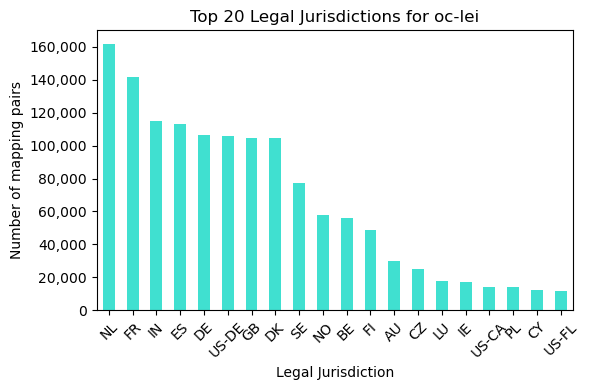

In [12]:
top20 = in_scope_mapping_level1['Entity.LegalJurisdiction'].value_counts().head(20)

Visualizations.draw_bar_chart_jurisdictions(top20, mapping_pairs)

The below code shows the current number of mappings in the LEI system. The LEI is depicted in the center, serving as the linchpin of the mapped identifiers.

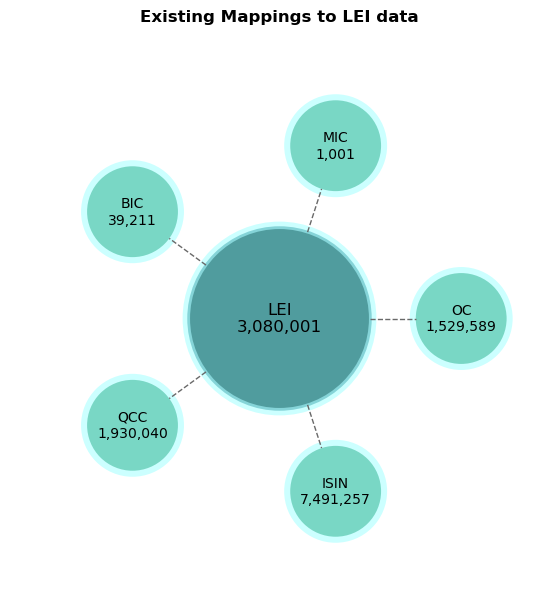

In [13]:
Visualizations.draw_star_map(
    center_label="LEI",
    center_value=level_1_data.shape[0],
    data=(
        ("OC", by_mapping["oc-lei"].shape[0]),
        ("MIC", by_mapping["mic-lei"].shape[0]),
        ("BIC", by_mapping["bic-lei"].shape[0]),
        ("QCC", by_mapping["qcc-lei"].shape[0]),
        ("ISIN", by_mapping["isin-lei"].shape[0]),
    ),
)

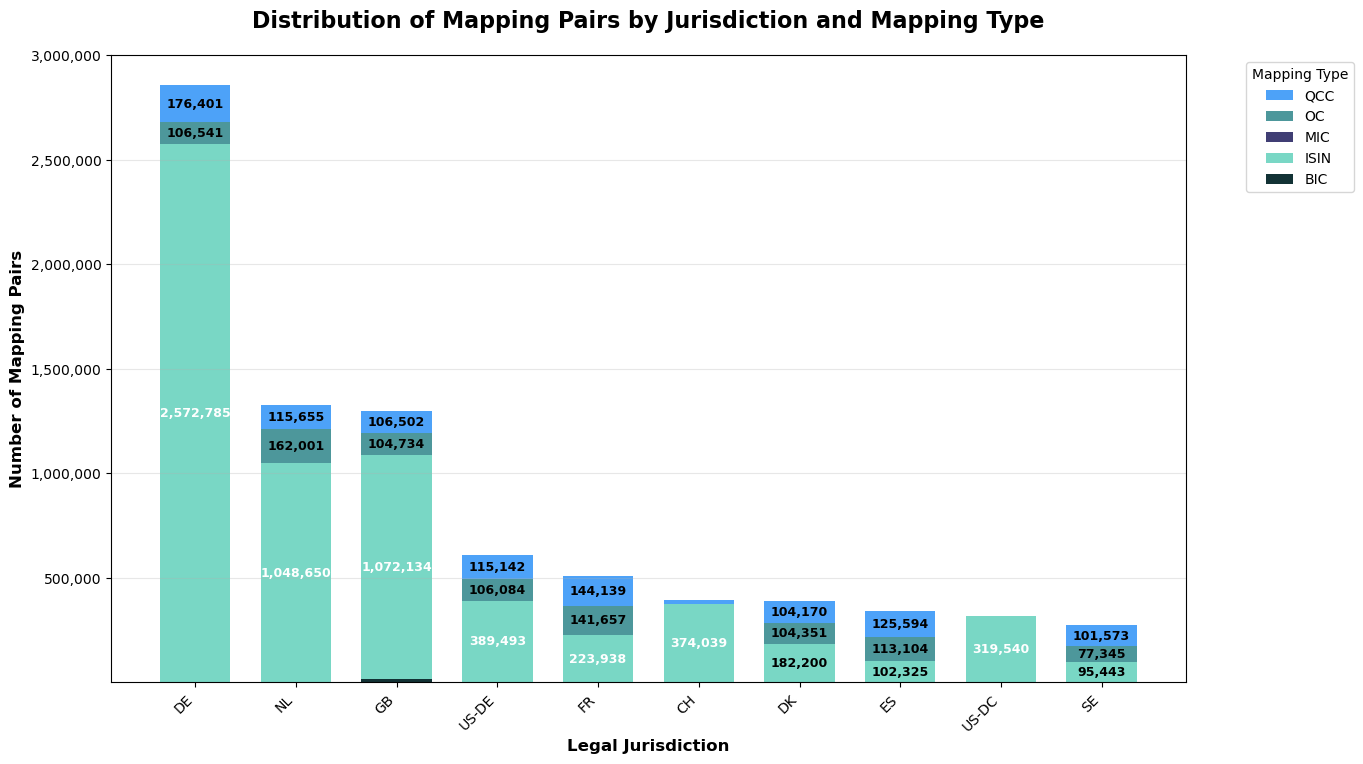


Detailed Breakdown by Jurisdiction:

DE:
  BIC: 1,848 (0.1%)
  ISIN: 2,572,785 (90.0%)
  MIC: 71 (0.0%)
  OC: 106,541 (3.7%)
  QCC: 176,401 (6.2%)
  Total: 2,857,646

NL:
  BIC: 455 (0.0%)
  ISIN: 1,048,650 (79.0%)
  MIC: 56 (0.0%)
  OC: 162,001 (12.2%)
  QCC: 115,655 (8.7%)
  Total: 1,326,817

GB:
  BIC: 17,053 (1.3%)
  ISIN: 1,072,134 (82.4%)
  MIC: 175 (0.0%)
  OC: 104,734 (8.1%)
  QCC: 106,502 (8.2%)
  Total: 1,300,598

US-DE:
  BIC: 958 (0.2%)
  ISIN: 389,493 (63.7%)
  MIC: 143 (0.0%)
  OC: 106,084 (17.3%)
  QCC: 115,142 (18.8%)
  Total: 611,820

FR:
  BIC: 1,573 (0.3%)
  ISIN: 223,938 (43.8%)
  MIC: 45 (0.0%)
  OC: 141,657 (27.7%)
  QCC: 144,139 (28.2%)
  Total: 511,352

CH:
  BIC: 926 (0.2%)
  ISIN: 374,039 (94.6%)
  MIC: 18 (0.0%)
  QCC: 20,446 (5.2%)
  Total: 395,429

DK:
  BIC: 211 (0.1%)
  ISIN: 182,200 (46.6%)
  MIC: 14 (0.0%)
  OC: 104,351 (26.7%)
  QCC: 104,170 (26.6%)
  Total: 390,946

ES:
  BIC: 418 (0.1%)
  ISIN: 102,325 (30.0%)
  MIC: 22 (0.0%)
  OC: 113,104 (33.1%)


In [14]:
# Create stacked bar charts using matplotlib
try:
    data_matrix, jurisdictions, mapping_labels = (
        Visualizations.create_matplotlib_stacked_chart(
            by_mapping, level_1_data[["LEI", "Entity.LegalJurisdiction"]], top_n=10
        )
    )
except Exception as e:
    print(f"Error creating matplotlib chart: {e}")
    traceback.print_exc()

### Retrieve mappings using the GLEIF API

Instead of downloading the entire LEI data and the mapping tables, it is also possible to query individual LEI records via the GLEIF API. As part of the API response, users can access mapped identifiers.

As there can be a large number of ISINs mapped to one LEI record, the GLEIF API makes these available via a dedicated endpoint. The below method uses this dedicated endpoint to retrieve all mapped ISIN codes for a given LEI.

In [15]:
def fetch_isins(self, lei: str, page_size: int = 1000):
    """
    Return ALL ISINs linked to an LEI (paginated endpoint).
    Uses large page size to minimize requests.
    """
    isins: List[str] = []
    page = 1
    max_pages = 1000  # safety limit

    while page <= max_pages:
        params = {
            "page[number]": page,
            "page[size]": page_size,
            "fields[isins]": "isin,lei",  # sparse fieldset
        }
        payload = self._get(f"lei-records/{lei}/isins", params=params)
        data = payload.get("data", []) or []
        if not data:
            break

        for item in data:
            isin = (item.get("attributes") or {}).get("isin")
            if isin:
                isins.append(isin)

        # Prefer link-based pagination if present, else increment
        next_url = (payload.get("links") or {}).get("next")
        if next_url:
            # If server provides a next URL, use it (handles cursor pagination)
            payload = self._get(next_url)
            data = payload.get("data", []) or []
            if not data:
                break
            for item in data:
                isin = (item.get("attributes") or {}).get("isin")
                if isin:
                    isins.append(isin)
            # We consumed the next page already; continue with numeric increment by 2
            page += 2
            continue

        page += 1

    # Deduplicate while preserving order (just in case)
    seen = set()
    return [x for x in isins if not (x in seen or seen.add(x))]


The method below will retrieve MIC, BIC, Open Corporates ID, S&P CIQ Company ID and the QCC identifier from the API response. Additionally, the method utilizes the fetch_isins method to construct a final dataframe, containing all mappings for a given LEI record:

In [16]:
def build_dataframes(
    self,
    leis: Iterable[str],
    attr_keys: Tuple[str, ...] = ("mic", "bic", "ocid", "qcc", "spglobal"),
):
    """
    returns df_summary: one row per LEI with all available mappings, including RegistrationAuthorityID and RegistrationAuthorityEntityID

    """
    rows = []
    isin_rows = []

    for lei in leis:
        attrs = self.fetch_lei_attrs(lei)

        attr_row = {k: attrs.get(k) for k in attr_keys}

        # Extract RegistrationAuthorityID (registeredAt) and RegistrationAuthorityEntityID (registeredAs)
        entity = attrs.get("entity", {})
        legalname = entity.get("legalName", {}).get("name") if entity else None
        registered_at_id = entity.get("registeredAt", {}).get("id") if entity else None
        registered_as = entity.get("registeredAs") if entity else None

        isins = fetch_isins(self, lei)
        codelists = Codelists()
        rows.append(
            {
                "lei": lei,
                "LegalName": legalname,
                "RegistrationAuthorityID": registered_at_id,
                "RegistrationAuthorityName": codelists.addRegistrationauthorityName(registered_at_id)['registration_authority_name'][0],
                "RegistrationAuthorityEntityID": registered_as,
                **attr_row,
                "isins": isins,
            }
        )
        for isin in isins:
            isin_rows.append({"lei": lei, "isin": isin})

    df_summary = pd.DataFrame(rows)
    return df_summary

Using the mapped identifiers, in combination with the RegistrationAuthorityID and the RegistrationAuthorityEntityID allows data users to seamlessly link datasets. Additionally, the ValidationAuthorityEntityID and (where available) the OtherValidationAuthorityEntityID can be used as additional mapping elements.

In [17]:
# Pass the LEIs of interest to the method
random_leis = ["353800578ADEGIJTVW07", "529900E7W7M9W46YY476"]

client = GLEIFAPI()
df_summary = build_dataframes(client, random_leis)
df_summary


,lei,LegalName,RegistrationAuthorityID,RegistrationAuthorityName,RegistrationAuthorityEntityID,mic,bic,ocid,qcc,spglobal,isins
0,353800578ADEGIJTVW07,株式会社日本取引所グループ,RA000412,Companies Registration | Legal Affairs Bureau ...,1200-01-098575,[XJPX],None,jp/9120001098575,QJPJQNMX5E,[41262511],"[JP3183200009, JP318320AHF7]"
1,529900E7W7M9W46YY476,德意志银行(中国)有限公司,RA000092,National Enterprise Credit Information Publici...,91110000669904618N,None,"[DEUTCNBJXXX, DEUTCNSHBJG]",None,QCNM4GW5W8,[41358413],[]


It is also possible to use one of the mapped identifiers to look up an LEI record. The method below allows choosing an arbitrary mapped identifier and returns the associated LEI.

In [18]:
def retrieve_lei_with_mapping(client, mapped_identifier: str, mapping_type: str):
    """
    Retrieve LEI records based on mapped identifiers (BIC, MIC, OCID, QCC, etc.).
    
    Args:
        client: GLEIFAPI client instance
        mapped_identifier: The mapped identifier value (e.g., BIC code, MIC code, etc.)
        mapping_type: Type of mapped identifier ('bic', 'isin', 'mic', 'ocid', 'qcc', 'spglobal')
        
    Returns:
        DataFrame with LEI and mapped identifier columns
    """
    # Validate mapping type
    valid_types = ['bic', 'isin','mic', 'ocid', 'qcc', 'spglobal']
    if mapping_type.lower() not in valid_types:
        raise ValueError(f"Invalid mapping type '{mapping_type}'. Must be one of: {valid_types}")
    
    try:
        # Use the correct GLEIF API filter format: filter[param]=value
        filter_param = f"filter[{mapping_type.lower()}]"
        params = {filter_param: mapped_identifier}
        
        # Use the GLEIFAPI client to make the request
        payload = client._get("lei-records", params=params)
        
        # Extract LEI records from the response
        lei_records = []
        if 'data' in payload and payload['data']:
            for record in payload['data']:
                lei = record.get('id', '')
                attributes = record.get('attributes', {})
                
                # Get the mapped identifier value from attributes
                mapped_value = attributes.get(mapping_type.lower(), mapped_identifier)
                
                lei_records.append({
                    'lei': lei,
                    'mapped_identifier': mapped_value,
                    'mapping_type': mapping_type.upper()
                })
        
        # Create DataFrame
        if lei_records:
            df_result = pd.DataFrame(lei_records)
            print(f"Found {len(lei_records)} LEI record(s) for {mapping_type.upper()} '{mapped_identifier}'")
            return df_result
        else:
            print(f"No LEI records found for {mapping_type.upper()} '{mapped_identifier}'")
            return pd.DataFrame(columns=['lei', 'mapped_identifier', 'mapping_type'])
            
    except Exception as e:
        print(f"Error retrieving LEI data: {e}")
        return pd.DataFrame(columns=['lei', 'mapped_identifier', 'mapping_type'])



In [19]:
print(retrieve_lei_with_mapping(client, "DEUTCNBJXXX", "bic"))
print('---')
print(retrieve_lei_with_mapping(client, "JP318320AHF7", "isin"))
print('---')
print(retrieve_lei_with_mapping(client, "XJPX", "mic"))
print('---')
print(retrieve_lei_with_mapping(client, "jp/9120001098575", "ocid"))
print('---')
print(retrieve_lei_with_mapping(client, "QCNM4GW5W8", "qcc"))
print('---')
print(retrieve_lei_with_mapping(client, "41358413", "spglobal"))





Found 1 LEI record(s) for BIC 'DEUTCNBJXXX'
                    lei           mapped_identifier mapping_type
0  529900E7W7M9W46YY476  [DEUTCNBJXXX, DEUTCNSHBJG]          BIC
---
Found 1 LEI record(s) for ISIN 'JP318320AHF7'
                    lei mapped_identifier mapping_type
0  353800578ADEGIJTVW07      JP318320AHF7         ISIN
---
Found 1 LEI record(s) for MIC 'XJPX'
                    lei mapped_identifier mapping_type
0  353800578ADEGIJTVW07            [XJPX]          MIC
---
Found 1 LEI record(s) for OCID 'jp/9120001098575'
                    lei mapped_identifier mapping_type
0  353800578ADEGIJTVW07  jp/9120001098575         OCID
---
Found 1 LEI record(s) for QCC 'QCNM4GW5W8'
                    lei mapped_identifier mapping_type
0  529900E7W7M9W46YY476        QCNM4GW5W8          QCC
---
Found 1 LEI record(s) for SPGLOBAL '41358413'
                    lei mapped_identifier mapping_type
0  529900E7W7M9W46YY476        [41358413]     SPGLOBAL


#### <p style="text-align: left;">Resources:</p>

GoldenCopy Files: https://www.gleif.org/en/lei-data/gleif-golden-copy/download-the-golden-copy#/<br>
BIC-LEI Mapping: https://www.gleif.org/en/lei-data/lei-mapping/download-bic-to-lei-relationship-files#<br> 
ISIN-LEI Mapping: https://www.gleif.org/en/lei-data/lei-mapping/download-isin-to-lei-relationship-files#<br> 
MIC-LEI Mapping: https://www.gleif.org/en/lei-data/lei-mapping/download-mic-to-lei-relationship-files#<br> 
S&P CIQ Company ID-LEI Mapping: https://www.gleif.org/en/lei-data/lei-mapping/s-and-p-c-i-q-company-id-to-lei-relationship#<br> 
OpenCorporates ID-LEI Mapping: https://www.gleif.org/en/lei-data/lei-mapping/download-oc-to-lei-relationship-files#<br> 
QCC-LEI Mapping: https://www.gleif.org/en/lei-data/lei-mapping/download-qcc-to-lei-relationship-files#<br> 

